# Azure AI Custom vision object detection project export

This notebook demonstrates how to export all images and labels from an Azure AI Custom Vision object detection project.

In [1]:
#%pip install azure-cognitiveservices-vision-customvision

In [2]:
import csv
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import sys
import time

from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from collections import Counter
from msrest.authentication import ApiKeyCredentials
from PIL import Image

In [3]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

## 1. Settings

In [4]:
# Azure Custom Vision
ENDPOINT = "https://eastus.api.cognitive.microsoft.com/"
TRAINING_KEY = "fc72c3ece03d45cc93932ee6f96af4d8"

PROJECT_ID = "86959367-35e2-4a1e-9739-eab331a91cbc"

In [5]:
OUTPUT_DIR = "object_detection_project"

IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
LABELS_DIR = os.path.join(OUTPUT_DIR, "labels")

## 2. Helper

In [26]:
def create_directories():
    """Dirs creation"""
    os.makedirs(IMAGES_DIR, exist_ok=True)
    os.makedirs(LABELS_DIR, exist_ok=True)
    print(f"✅ Done. OUTPUT_DIR: {OUTPUT_DIR}")


def get_trainer_client():
    """ Get Azure Custom Vision client """
    credentials = ApiKeyCredentials(in_headers={"Training-key": TRAINING_KEY})
    trainer = CustomVisionTrainingClient(ENDPOINT, credentials)
    print(f"✅ Done")
    return trainer


def get_all_tags(trainer, project_id):
    """ Get all tags from the project """
    tags = trainer.get_tags(project_id)
    tag_dict = {tag.id: tag.name for tag in tags}
    print(f"✅ Done")
    print(f"{len(tag_dict)} TAGS: {list(tag_dict.values())}")
    return tag_dict


def get_tagged_images(trainer, project_id, batch_size=50):
    """ All tagged images """
    all_images = []
    skip = 0

    while True:
        images = trainer.get_tagged_images(project_id,
                                           take=batch_size,
                                           skip=skip)

        if not images:
            break

        all_images.extend(images)
        print(f"Processed {len(all_images)} images...")
        skip += batch_size

        if len(images) < batch_size:
            break

    print(f"\n✅ Done")
    print(f"Total: {len(all_images)} tagged images")
    return all_images


def download_image(url, filepath):
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        with open(filepath, 'wb') as f:
            f.write(response.content)
        return True
    except Exception as e:
        print(f"❌ Error: {e}")
        return False


def images_view(image_dir, n=12, cols=4):
    """
    Display images with size and dimension info.
    """
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp'}

    image_files = sorted([
        f for f in os.listdir(image_dir)
        if os.path.splitext(f)[1].lower() in valid_extensions
    ])[:n]

    if not image_files:
        print(f"⚠️ No images found in {image_dir}")
        return

    rows = (len(image_files) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4.5 * rows))
    axes = axes.flatten() if len(image_files) > 1 else [axes]

    print(f"🖼️ Displaying {len(image_files)} images from: {image_dir}\n")

    for idx, ax in enumerate(axes):
        if idx < len(image_files):
            img_path = os.path.join(image_dir, image_files[idx])
            img = Image.open(img_path)
            file_size = os.path.getsize(img_path) / 1024  # KB

            ax.imshow(img)
            ax.set_title(
                f"{image_files[idx][:15]}...\n{img.size[0]}x{img.size[1]} | {file_size:.1f}KB",
                fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


def export_to_yolo_format(images, tag_dict, labels_dir):
    """
    Export annotations to YOLO format with debugging.
    """
    # Create mapping tag_id -> class_id
    tag_ids = list(tag_dict.keys())
    tag_to_class = {tag_id: idx for idx, tag_id in enumerate(tag_ids)}

    # Save classes.txt
    classes_file = os.path.join(os.path.dirname(labels_dir), "classes.txt")
    with open(classes_file, 'w', encoding='utf-8') as f:
        for tag_id in tag_ids:
            f.write(f"{tag_dict[tag_id]}\n")

    # Debug: Check first image
    print(f"\n🔍 Debug - First image inspection:")
    if images:
        img = images[0]
        print(f"   Image ID: {img.id}")
        print(f"   Has regions attr: {hasattr(img, 'regions')}")
        print(f"   Regions: {img.regions}")
        print(f"   Regions type: {type(img.regions)}")
        if img.regions:
            print(f"   Number of regions: {len(img.regions)}")
            region = img.regions[0]
            print(f"   First region: {region}")
            print(f"   Region attributes: {dir(region)}")
            print(f"   tag_id: {region.tag_id}")
            print(f"   left: {region.left}, top: {region.top}")
            print(f"   width: {region.width}, height: {region.height}")

    files_with_annotations = 0
    total_annotations = 0

    for image in images:
        filename = f"{image.id}.txt"
        filepath = os.path.join(labels_dir, filename)

        with open(filepath, 'w') as f:
            if image.regions and len(image.regions) > 0:
                for region in image.regions:
                    class_id = tag_to_class.get(region.tag_id, 0)

                    # Convert (left, top, width, height) to (x_center, y_center, width, height)
                    x_center = region.left + region.width / 2
                    y_center = region.top + region.height / 2

                    f.write(
                        f"{class_id} {x_center:.6f} {y_center:.6f} {region.width:.6f} {region.height:.6f}\n"
                    )
                    total_annotations += 1

                files_with_annotations += 1

    print(f"\n📊 YOLO Export Summary:")
    print(f"   📁 Total files created: {len(images)}")
    print(f"   ✅ Files with annotations: {files_with_annotations}")
    print(f"   🏷️  Total annotations written: {total_annotations}")
    print(f"   ⚠️  Empty files: {len(images) - files_with_annotations}")


def parse_yolo_label(label_path, img_width, img_height):
    """Parse YOLO format label file and convert to pixel coordinates."""
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * img_width
                    y_center = float(parts[2]) * img_height
                    width = float(parts[3]) * img_width
                    height = float(parts[4]) * img_height

                    # Convert to top-left corner
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2

                    boxes.append((class_id, x1, y1, width, height))
    return boxes


def images_view(images_dir, labels_dir, num_images=10):
    """Display images with their bounding boxes."""
    # Get image files
    image_extensions = ('.jpg', '.jpeg', '.png')
    image_files = sorted([
        f for f in os.listdir(images_dir)
        if f.lower().endswith(image_extensions)
    ])[:num_images]

    # Create figure
    cols = 2
    rows = (len(image_files) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten() if len(image_files) > 1 else [axes]

    for idx, img_file in enumerate(image_files):
        # Load image
        img_path = os.path.join(images_dir, img_file)
        img = Image.open(img_path)
        img_width, img_height = img.size

        # Get corresponding label file
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)

        # Parse labels
        boxes = parse_yolo_label(label_path, img_width, img_height)

        # Display image
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_file}\n({len(boxes)} objects)", fontsize=14)
        axes[idx].axis('off')

        # Draw bounding boxes
        colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink', 'yellow', 'teal', 'coral', 'navy', 'maroon', 'salmon']
        
        for class_id, x, y, w, h in boxes:
            color = colors[class_id % len(colors)]
            rect = patches.Rectangle((x, y),
                                     w,
                                     h,
                                     linewidth=5,
                                     edgecolor=color,
                                     facecolor='none',
                                    )
            axes[idx].add_patch(rect)
            
            axes[idx].text(x,
                           y - 30,
                           f'Label {class_id+1}: {list(tag_dict.values())[class_id]}',
                           color=color,
                           fontsize=12,
                           bbox=dict(boxstyle='round',
                                     facecolor='white',
                                     alpha=0.8))

    # Hide empty subplots
    for idx in range(len(image_files), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

## 4. Creating dirs

In [7]:
create_directories()

✅ Done. OUTPUT_DIR: object_detection_project


## 5. Get tags

In [8]:
trainer = get_trainer_client()

✅ Done


In [9]:
project = trainer.get_project(PROJECT_ID)
print(f"Azure Custom Vision project: {project.name}")

Azure Custom Vision project: Cable quality control


In [10]:
tag_dict = get_all_tags(trainer, PROJECT_ID)

✅ Done
2 TAGS: ['break', 'thunderbolt']


In [11]:
tag_dict

{'4479b7c4-902a-452e-83a6-6333a2ccc014': 'break',
 'b6cd370e-a012-4aae-9f45-fc5c20016341': 'thunderbolt'}

## 6. Get images

In [12]:
images = get_tagged_images(trainer, PROJECT_ID)

Processed 50 images...
Processed 100 images...
Processed 150 images...
Processed 200 images...
Processed 250 images...
Processed 300 images...
Processed 350 images...
Processed 400 images...
Processed 450 images...
Processed 500 images...
Processed 550 images...
Processed 600 images...
Processed 650 images...
Processed 700 images...
Processed 750 images...
Processed 800 images...
Processed 850 images...
Processed 900 images...
Processed 918 images...

✅ Done
Total: 918 tagged images


In [13]:
len(images)

918

##  7. Downloading all images from the project

In [14]:
print("Downloading all images...")

start = time.time()
success_count = 0
error_count = 0

for idx, image in enumerate(images):
    filename = f"{image.id}.jpg"
    filepath = os.path.join(IMAGES_DIR, filename)

    if download_image(image.original_image_uri, filepath):
        success_count += 1
    else:
        error_count += 1

    if (idx + 1) % 100 == 0 or idx == len(images) - 1:
        print(f"  Please wait. Processing {idx + 1}/{len(images)} images.")

print(f"\n✅ Done")
minutes, seconds = divmod((time.time() - start), 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

  Please wait. Processing 100/918 images.
  Please wait. Processing 200/918 images.
  Please wait. Processing 300/918 images.
  Please wait. Processing 400/918 images.
  Please wait. Processing 500/918 images.
  Please wait. Processing 600/918 images.
  Please wait. Processing 700/918 images.
  Please wait. Processing 800/918 images.
  Please wait. Processing 900/918 images.
  Please wait. Processing 918/918 images.

✅ Done
Elapsed time = 9 minutes and 34 seconds


### Images without the labels

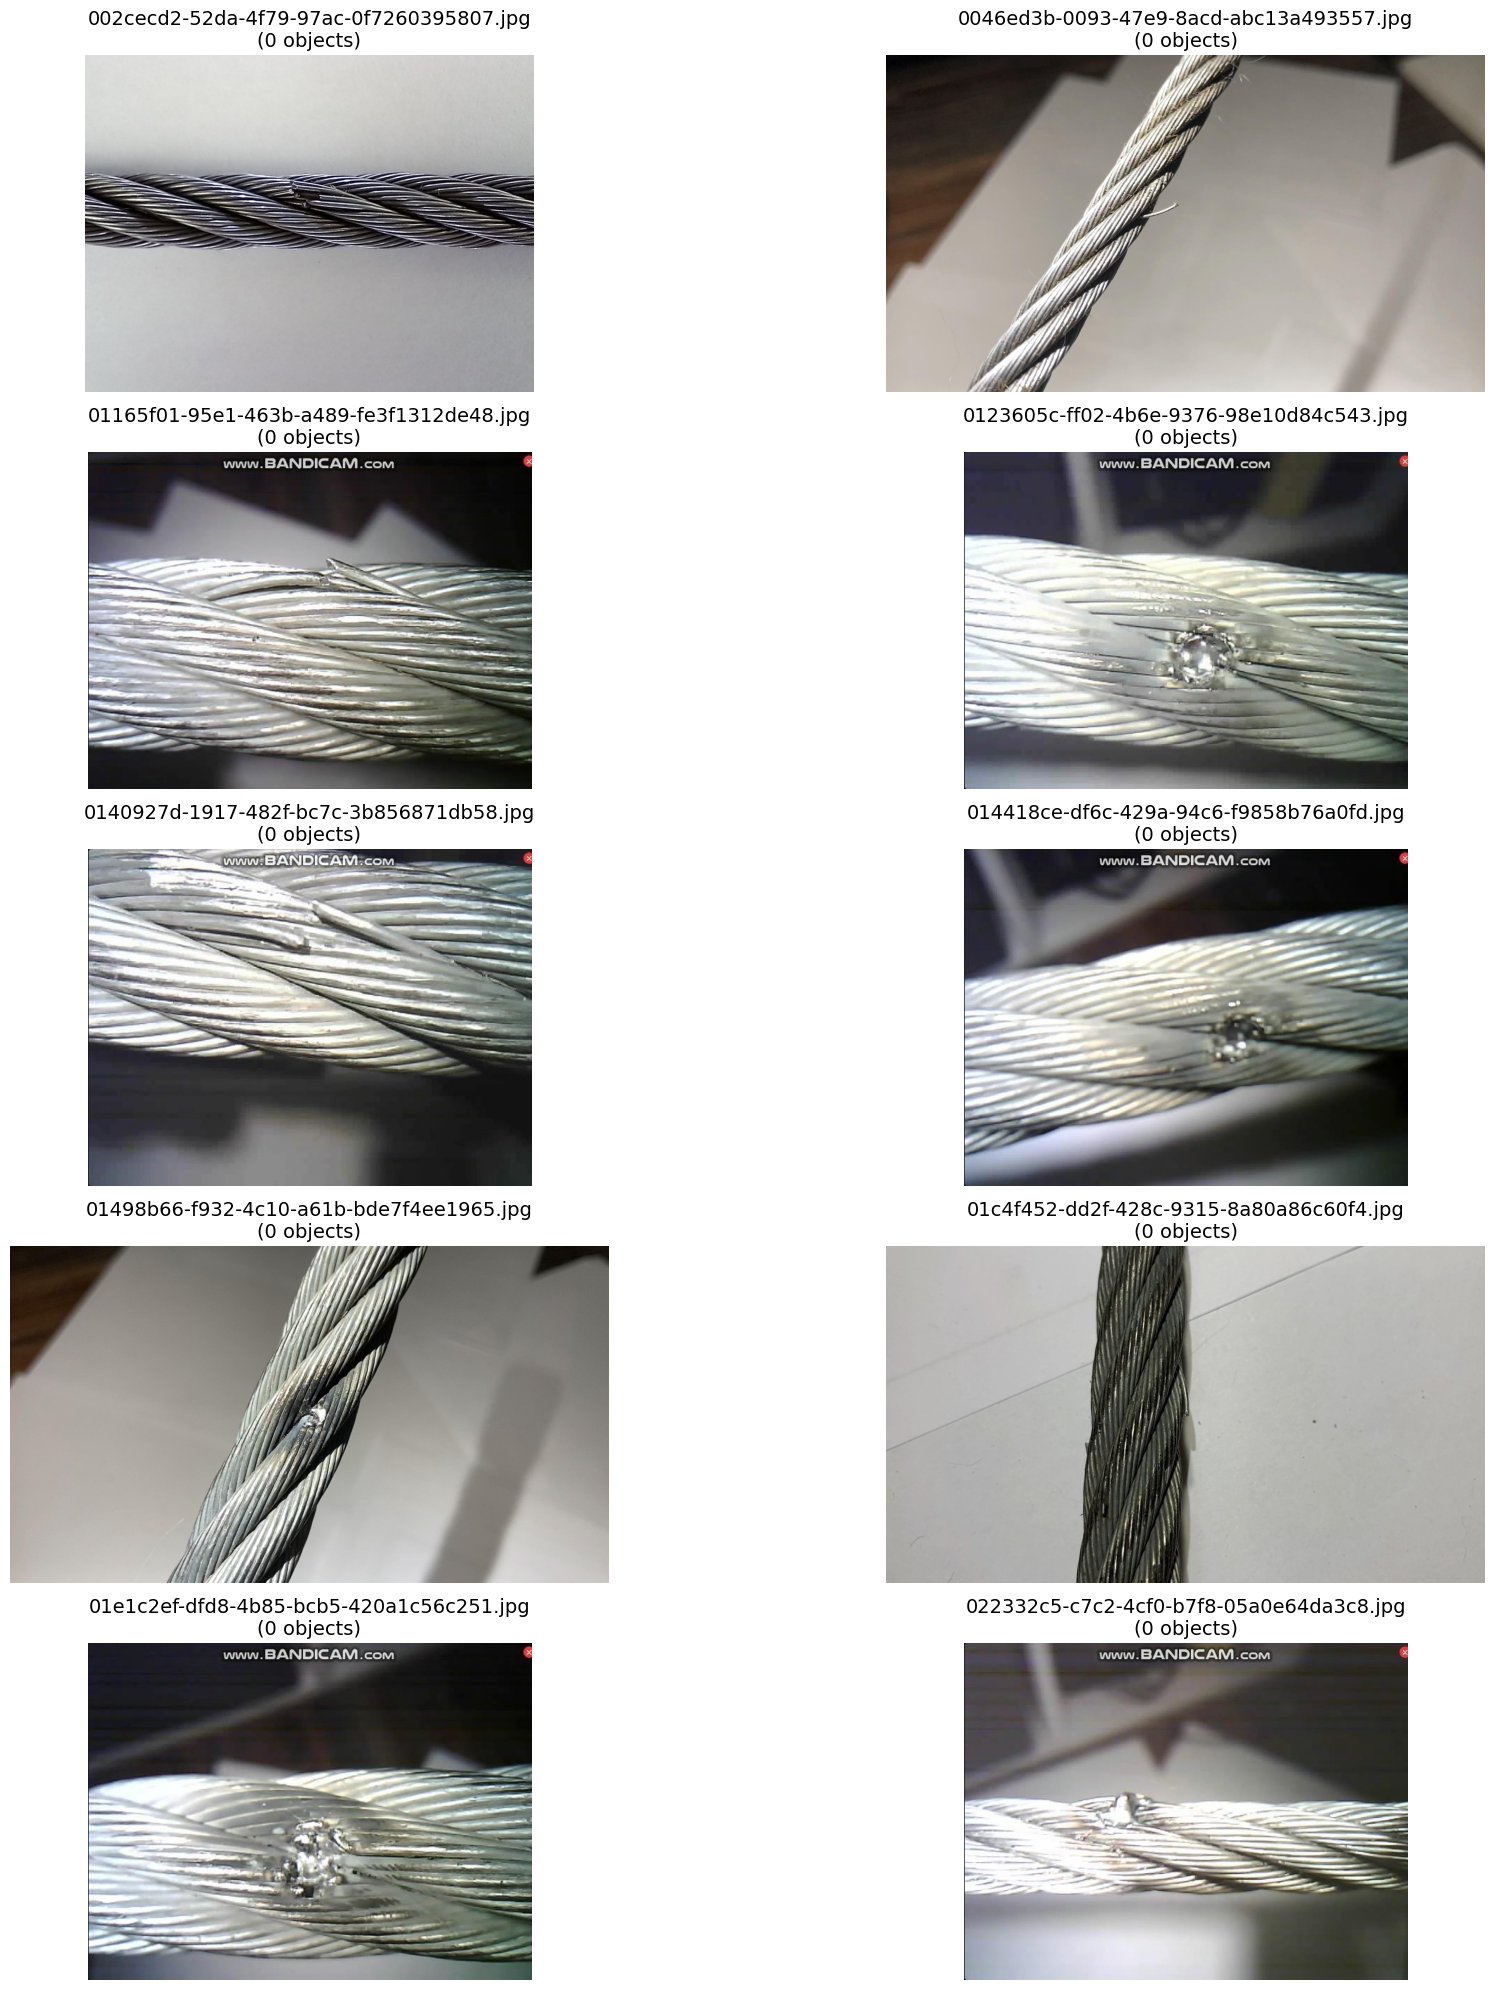

In [18]:
images_view(IMAGES_DIR, LABELS_DIR, num_images=10)

## 8. Tags export to YOLO

In [19]:
tag_dict

{'4479b7c4-902a-452e-83a6-6333a2ccc014': 'break',
 'b6cd370e-a012-4aae-9f45-fc5c20016341': 'thunderbolt'}

In [20]:
print(f"Label 1: {list(tag_dict.values())[0]}")
print(f"Label 2: {list(tag_dict.values())[1]}")

Label 1: break
Label 2: thunderbolt


In [21]:
export_to_yolo_format(images, tag_dict, LABELS_DIR)


🔍 Debug - First image inspection:
   Image ID: 095a0dbe-724b-43f0-a5f4-91a5c4dc7c51
   Has regions attr: True
   Regions: [<azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageRegion object at 0x75689892af20>, <azure.cognitiveservices.vision.customvision.training.models._models_py3.ImageRegion object at 0x75689892a260>]
   Regions type: <class 'list'>
   Number of regions: 2
   First region: {'additional_properties': {}, 'region_id': '495675a1-0b47-401a-965b-de88acb7a0ed', 'tag_name': 'break', 'created': datetime.datetime(2022, 11, 22, 10, 42, 4, 724644), 'tag_id': '4479b7c4-902a-452e-83a6-6333a2ccc014', 'left': 0.42424244, 'top': 0.41811848, 'width': 0.09305785, 'height': 0.13550523}
   Region attributes: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', 

### Images with the labels

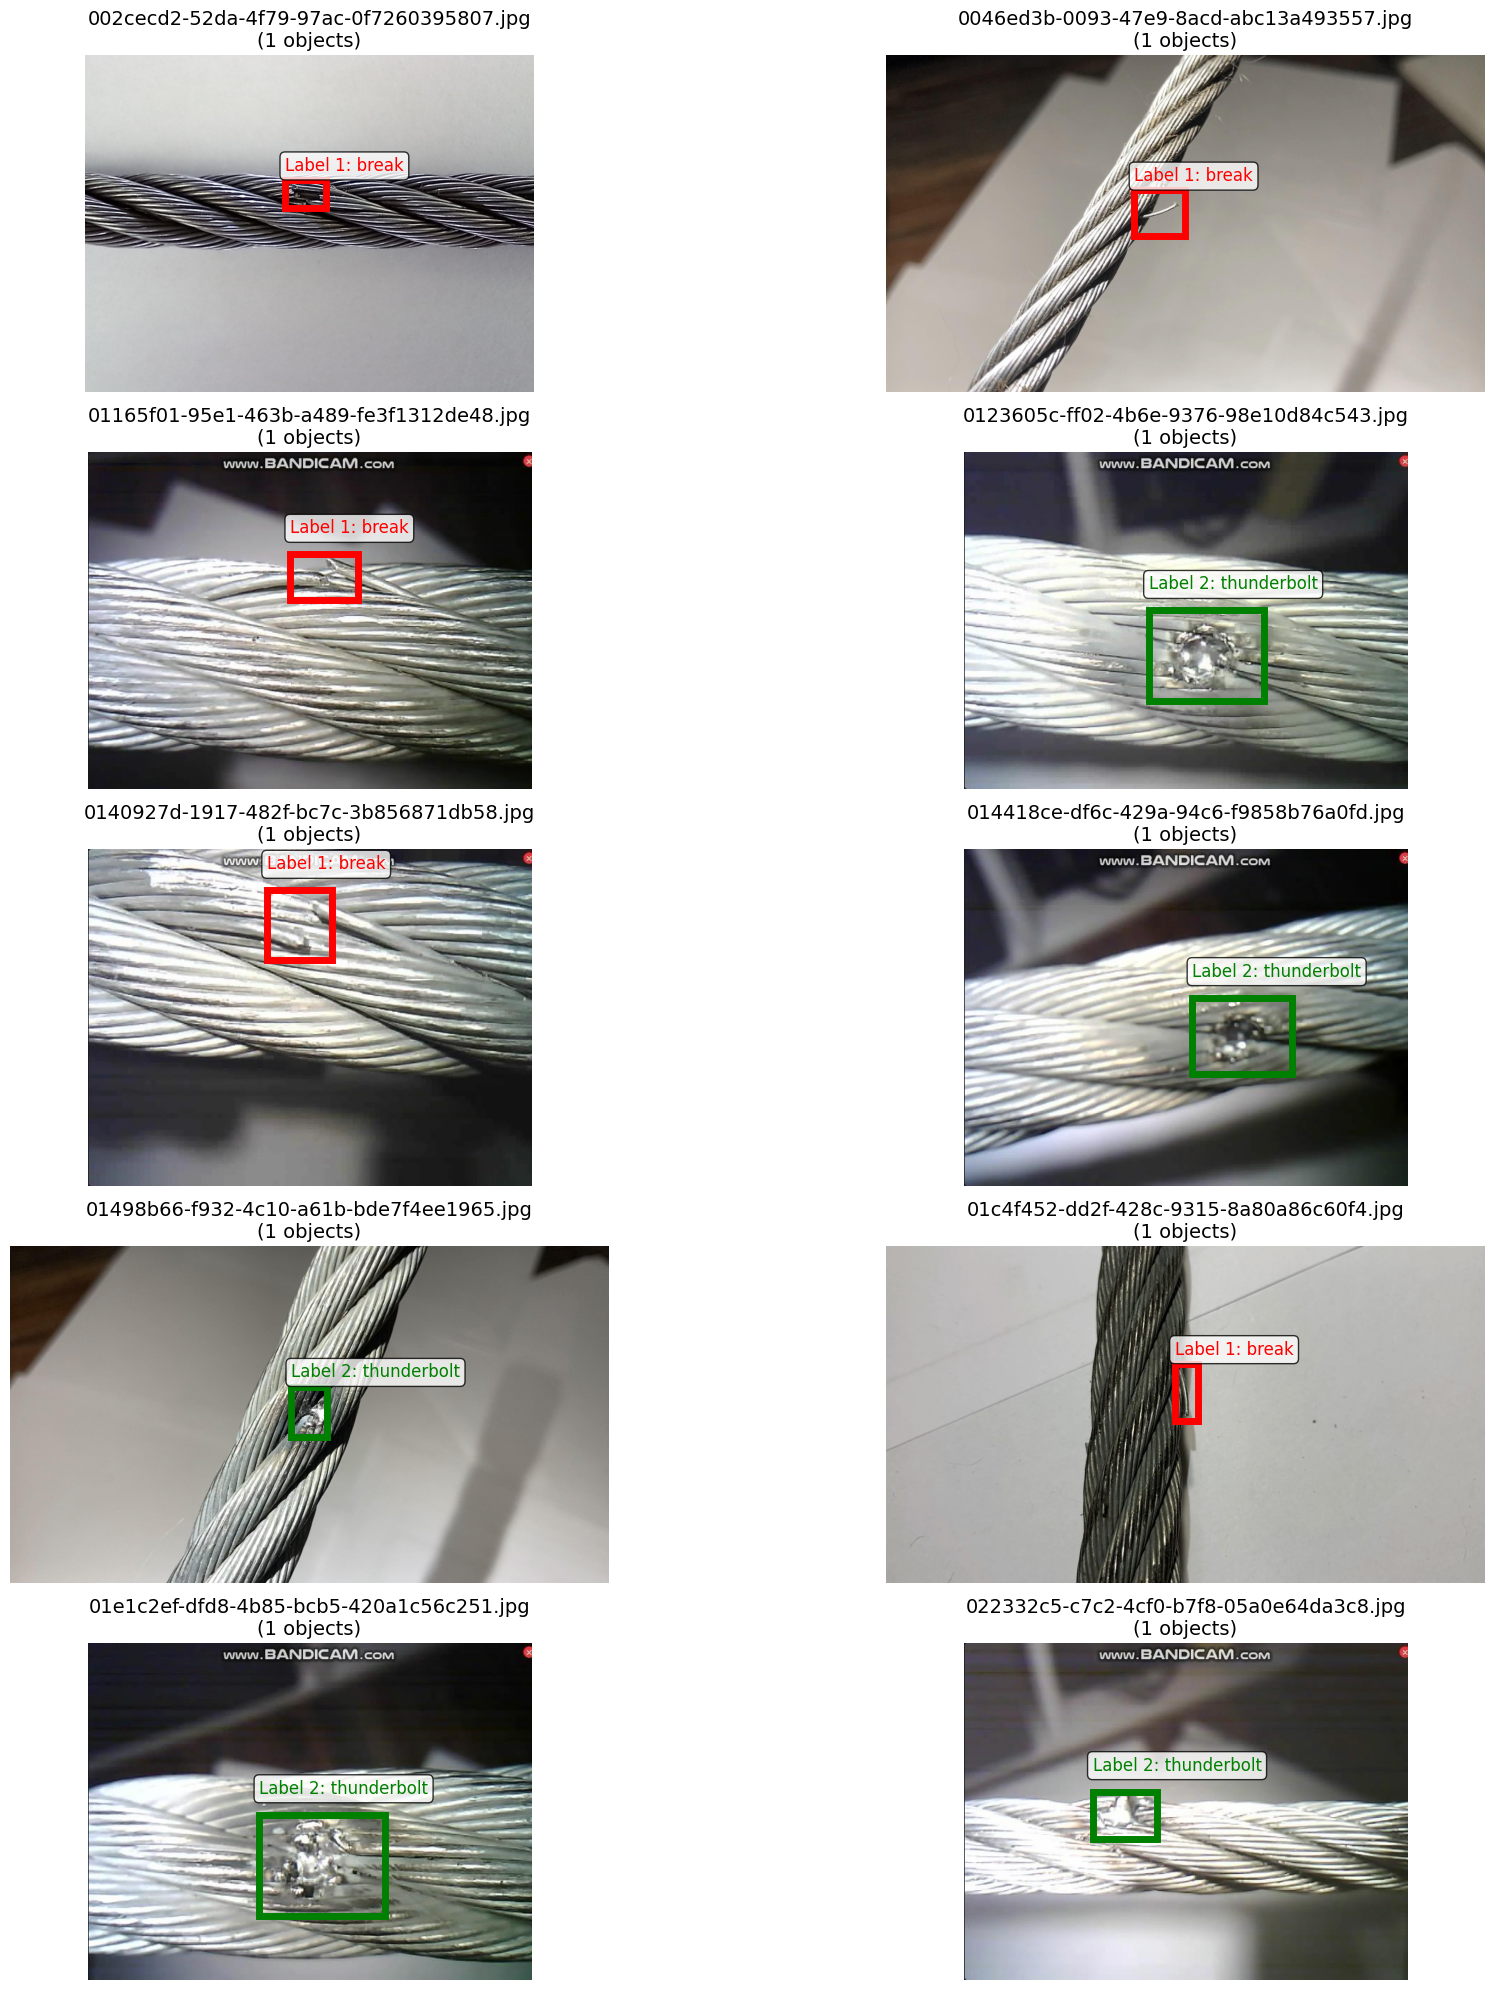

In [27]:
images_view(IMAGES_DIR, LABELS_DIR, num_images=10)

## 9. Status

In [23]:
print(f"✅ Downloaded images = {success_count}")
print(f"❌ Errors = {error_count}")

✅ Downloaded images = 918
❌ Errors = 0
